In [108]:
### Pseudocode

# Phase 1: Truck Route
# Solve truck-only TSP using method of choice (or compare multiple methods) - e.g, nearest neighbor, 2-opt, genetic algorithm
# Formulations are widely available

# Phase 2: Drone Integration
# Start with 1 drone
# Try delivering to each node using a drone instead of the truck separately and compapre savings (similar to Clark-Wright savings)
# Use drone travel time as fraction of truck travel time for simplicity
# If saving found, consider drone meeting truck while en route to next node
# If comfortable, try adding more drones and repeat above steps, including multiple drones delivering to different nodes simultaneously (trucks skipping two or more consecutive nodes in the route sequence)

## TSP: Euclidean distance formulation and plotting

This section formulates a Travelling Salesman Problem using Euclidean distances, solves it (exact for small n, heuristic 2-opt for larger n), and plots the final route.

Usage: run the cells below. The demo cell generates random points, solves the TSP, prints the route length, and shows a matplotlib plot.

In [109]:
# Imports and helper functions
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations


def euclidean_dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])


def distance_matrix(points):
    n = len(points)
    D = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i][j] = euclidean_dist(points[i], points[j])
    return D


def route_length(route, D):
    s = 0.0
    for k in range(len(route)):
        i = route[k]
        j = route[(k+1) % len(route)]
        s += D[i][j]
    return s


def plot_route(points, route, title=None):
    xs = [points[i][0] for i in route] + [points[route[0]][0]]
    ys = [points[i][1] for i in route] + [points[route[0]][1]]
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, '-o')
    for idx, (x, y) in enumerate(points):
        plt.text(x, y, str(idx))
    if title:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [110]:
# Exact solver for small n and 2-opt heuristic
from itertools import permutations


def tsp_exact(D):
    n = len(D)
    best = None
    best_len = float('inf')
    nodes = list(range(n))
    start = 0
    for perm in permutations(nodes[1:]):
        route = [start] + list(perm)
        l = route_length(route, D)
        if l < best_len:
            best_len = l
            best = route
    return best, best_len


def two_opt(route, D):
    n = len(route)
    improved = True
    best = route[:]
    best_len = route_length(best, D)
    while improved:
        improved = False
        for i in range(1, n-1):
            for j in range(i+1, n):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                new_len = route_length(new_route, D)
                if new_len < best_len:
                    best = new_route
                    best_len = new_len
                    improved = True
    return best, best_len


def tsp_solve(points):
    D = distance_matrix(points)
    n = len(points)
    if n <= 10:
        route, l = tsp_exact(D)
        method = 'exact'
    else:
        # nearest neighbor start
        start = 0
        un = set(range(n))
        route = [start]
        un.remove(start)
        while un:
            last = route[-1]
            nxt = min(un, key=lambda x: D[last][x])
            route.append(nxt)
            un.remove(nxt)
        route, l = two_opt(route, D)
        method = '2-opt'
    return route, l, D, method

Method: 2-opt, total length: 432.56
Route: [0, 8, 7, 3, 18, 5, 11, 9, 6, 19, 1, 2, 14, 17, 4, 13, 15, 12, 16, 10]


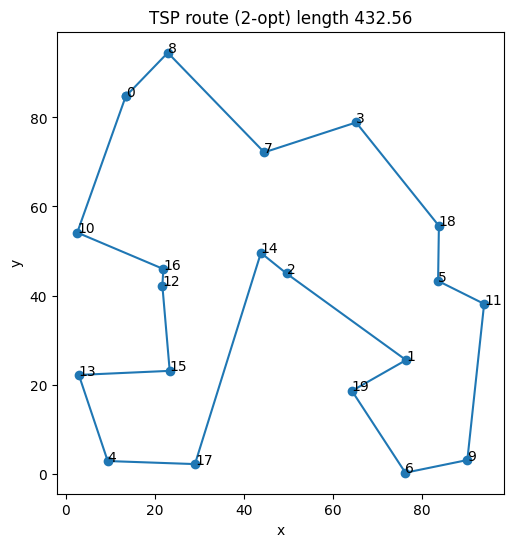

In [128]:
# Demo: generate points, solve, and plot
import random
random.seed(1)

n = 20  # change to <=10 for exact solve; increase for larger tests
points = [(random.random()*100, random.random()*100) for _ in range(n)]

truck_route, total_len, D, method = tsp_solve(points)
print(f"Method: {method}, total length: {total_len:.2f}")
print("Route:", truck_route)
plot_route(points, truck_route, title=f"TSP route ({method}) length {total_len:.2f}")

In [129]:
for i in range(len(truck_route)):
    print(f"Segment distance from {truck_route[i]} to {truck_route[(i+1)%len(truck_route)]}: {D[truck_route[i]][truck_route[(i+1)%len(truck_route)]]:.2f}")

print("")

skip_savings = []
drone_distances = []

for skip_idx in range(len(truck_route)):
    skip_savings.append((D[truck_route[skip_idx-1]][truck_route[skip_idx]] + D[truck_route[skip_idx]][truck_route[(skip_idx+1)%len(truck_route)]] - (D[truck_route[skip_idx-1]][truck_route[(skip_idx+1)%len(truck_route)]]), truck_route[skip_idx]))
    drone_distances.append(D[truck_route[skip_idx-1]][truck_route[skip_idx]] + D[truck_route[skip_idx]][truck_route[(skip_idx+1)%len(truck_route)]])
    print(f"Savings removing {truck_route[skip_idx]}: {skip_savings[skip_idx]}")
    print(f"Drone distance needed: {drone_distances[skip_idx]}")

drone_range = 60.0
best_drone_deliveries = sorted((skip_savings[i] for i in range(len(truck_route)) if drone_distances[i] <= drone_range), reverse=True)
print("\nBest drone deliveries within range:", best_drone_deliveries)

drone_points = []
for i in range(len(best_drone_deliveries)):
    drone_points.append(best_drone_deliveries[i][1])
if 0 in drone_points:
    drone_points.remove(0)

# Ensure no two drone points are adjacent in the truck route order
filtered_drone_points = []
for point in drone_points:
    # Check if the current point is adjacent to any point already in the filtered list
    is_adjacent = any(
        abs(truck_route.index(point) - truck_route.index(filtered_point)) == 1
        for filtered_point in filtered_drone_points
    )
    # Add the point only if it is not adjacent to any already in the filtered list
    if not is_adjacent:
        filtered_drone_points.append(point)

# Replace the original drone_points with the filtered list
drone_points = filtered_drone_points

Segment distance from 0 to 8: 13.60
Segment distance from 8 to 7: 31.14
Segment distance from 7 to 3: 21.69
Segment distance from 3 to 18: 29.76
Segment distance from 18 to 5: 12.37
Segment distance from 5 to 11: 11.55
Segment distance from 11 to 9: 35.26
Segment distance from 9 to 6: 14.20
Segment distance from 6 to 19: 21.95
Segment distance from 19 to 1: 13.98
Segment distance from 1 to 2: 33.14
Segment distance from 2 to 14: 7.39
Segment distance from 14 to 17: 49.69
Segment distance from 17 to 4: 19.60
Segment distance from 4 to 13: 20.39
Segment distance from 13 to 15: 20.42
Segment distance from 15 to 12: 19.20
Segment distance from 12 to 16: 3.76
Segment distance from 16 to 10: 20.99
Segment distance from 10 to 0: 32.48

Savings removing 0: (0.8629516059872344, 0)
Drone distance needed: 46.07788348114251
Savings removing 8: (11.183522943876646, 8)
Drone distance needed: 44.73713679512835
Savings removing 7: (7.741304206766863, 7)
Drone distance needed: 52.82931984486979
Savings

In [130]:
# After your existing code that creates drone_points, ADD THIS:

# Store drone operations as (launch, drone_customer, retrieval) tuples
drone_operations = []
for drone_point in drone_points:
    idx = truck_route.index(drone_point)
    launch = truck_route[idx - 1]  # previous point in route
    retrieval = truck_route[(idx + 1) % len(truck_route)]  # next point (wraps to depot)
    drone_operations.append((launch, drone_point, retrieval))

print("\nDrone operations (launch, customer, retrieval):")
for op in drone_operations:
    print(f"  Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")


Drone operations (launch, customer, retrieval):
  Launch from 19, deliver to 1, retrieve at 2
  Launch from 4, deliver to 13, retrieve at 15
  Launch from 16, deliver to 10, retrieve at 0
  Launch from 0, deliver to 8, retrieve at 7
  Launch from 2, deliver to 14, retrieve at 17
  Launch from 7, deliver to 3, retrieve at 18
  Launch from 11, deliver to 9, retrieve at 6
  Launch from 18, deliver to 5, retrieve at 11
  Launch from 15, deliver to 12, retrieve at 16


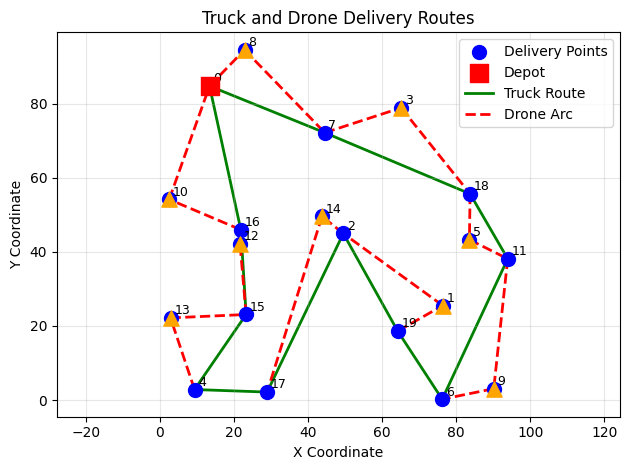

In [136]:
import matplotlib.pyplot as plt

def plot_routes_with_drones(points, truck_route, drone_operations):
    """
    Plots the truck and drone routes on a 2D map.
    
    Args:
        points (list of tuples): Coordinates of the points [(x1, y1), (x2, y2), ...].
        truck_route (list of int): Indices of points in the truck route (including depot).
        drone_operations (list of tuples): [(launch_idx, drone_customer_idx, retrieval_idx), ...]
    """
    # Extract drone customers for removal from truck route
    drone_customers = [op[1] for op in drone_operations]
    
    # Remove drone delivery points from the truck route
    updated_truck_route = [p for p in truck_route if p not in drone_customers]
    
    # Ensure the truck route is cyclic (connects last node back to the first)
    if updated_truck_route[-1] != updated_truck_route[0]:
        updated_truck_route.append(updated_truck_route[0])
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', label='Delivery Points', s=100, zorder=3)
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=150, label='Depot', zorder=4)
    
    # Annotate points with their indices
    for i, (px, py) in enumerate(points):
        plt.text(px + 1, py + 1, str(i), fontsize=9, ha='left')
    
    # Plot truck route
    for i in range(len(updated_truck_route) - 1):
        start, end = updated_truck_route[i], updated_truck_route[i + 1]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Plot drone arcs
    drone_label_added = False
    for launch, drone_cust, retrieval in drone_operations:
        # Launch arc (from truck to customer)
        plt.plot([points[launch][0], points[drone_cust][0]], 
                 [points[launch][1], points[drone_cust][1]], 
                 'r--', linewidth=2, label='Drone Arc' if not drone_label_added else "", zorder=2)
        # Retrieval arc (from customer back to truck)
        plt.plot([points[drone_cust][0], points[retrieval][0]], 
                 [points[drone_cust][1], points[retrieval][1]], 
                 'r--', linewidth=2, zorder=2)
        drone_label_added = True
        
        # Mark drone delivery points distinctly
        plt.scatter([points[drone_cust][0]], [points[drone_cust][1]], 
                   c='orange', marker='^', s=120, zorder=3)
    
    # Add legend and labels
    plt.legend(loc='best')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Truck and Drone Delivery Routes')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# Call the function with drone_operations instead of drone_points
plot_routes_with_drones(points, truck_route, drone_operations)